# Sprint-9：ニューラルネットワークのスクラッチ
___

In [51]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score

In [2]:
np.set_printoptions(threshold=30)

In [61]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [62]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

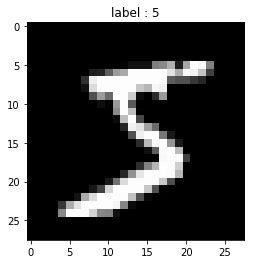

In [63]:
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [64]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [65]:
# enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
# y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
# y_test_one_hot = enc.transform(y_test[:, np.newaxis])
# print(y_train.shape) # (60000,)
# print(y_train_one_hot.shape) # (60000, 10)
# print(y_train_one_hot.dtype) # float64

In [66]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [67]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_val[:, np.newaxis])

## クラス：ScratchSimpleNeuralNetrowkClassifier

In [73]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(self, lr=0.0001, epoch=5, batch_size=20, n_features=784, n_nodes1=400, \
                 n_nodes2=200, n_output=10, active_method="t", verbose=True):
        
        self.verbose = verbose
        
        self.sigma = 0.01 # ガウス分布の標準偏差
        
        self.lr = lr

        self.epoch = epoch
        self.batch_size = batch_size # バッチサイズ
        self.n_features = n_features # 特徴量の数
        self.n_nodes1 = n_nodes1 # 1層目のノード数
        self.n_nodes2 = n_nodes2 # 2層目のノード数
        self.n_output = n_output # 出力のクラス数（3層目のノード数）

        # 第一層の重みとバイアスの初期値
        self.W1 = self.sigma * np.random.randn(self.n_features+1, self.n_nodes1)
        self.b1 = self.sigma * np.random.randn(self.n_nodes1)

        # 第二層の重みとバイアスの初期値
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.b2 = self.sigma * np.random.randn(self.n_nodes2)

        # 第三層の重みとバイアスの初期値
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.b3 = self.sigma * np.random.randn(self.n_output)
        
        self.L = []
        self.L_val = []
        
        self.active_method = active_method

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """

        X_with_bias = np.insert(X, 0 , 1, axis=1)
        
        if X_val is not None and y_val is not None:
            X_val_with_bias = np.insert(X_val, 0 , 1, axis=1)
        
        # Create mini-batch
        get_mini_batch = GetMiniBatch(X_with_bias, y, batch_size=self.batch_size)
        
        if X_val is not None and y_val is not None:
            X_val_with_bias = np.insert(X_val, 0 , 1, axis=1)
            
            mini_X_val_train = []
            mini_y_val_train = []
            
            get_mini_batch_val = GetMiniBatch(X_with_bias, y, batch_size=self.batch_size)
            for temp_X, temp_y in get_mini_batch_val:
                mini_X_val_train.append(temp_X)
                mini_y_val_train.append(temp_y)
        
        idx_for_val = 0
        for _ in range(self.epoch):
            for mini_X_train, mini_y_train in get_mini_batch:

                Z1, Z2, Z3, A1, A2 = self._forward_propa(mini_X_train)

                self.L.append(self._cross_entropy_error(mini_y_train, Z3))
                
                if X_val is not None and y_val is not None:
                    Z1_val, Z2_val, Z3_val, A1_val, A2_val = self._forward_propa(mini_X_val_train[idx_for_val])
                    self.L_val.append(self._cross_entropy_error(mini_y_val_train[idx_for_val], Z3_val))

                self._back_propa(mini_X_train, mini_y_train, Z1, Z2, Z3, A1, A2)
                
            idx_for_val = 0
        
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            
            fig = plt.figure(figsize=(12, 8))
            
            plt.plot(range(len(self.L)), self.L)
            
            if X_val is not None and y_val is not None:
                plt.plot(range(len(self.L_val)), self.L_val)
            
            plt.show

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """

        X_with_bias = np.insert(X, 0 , 1, axis=1)
        
        Z1, Z2, Z3, A1, A2 = self._forward_propa(X_with_bias)
        
#         rates = np.zeros(10)
        
#         for row in Z3:
            
#             idx = np.argmax(row)
#             rates[idx] += 1
        
#         return np.argmax(rates)
        return np.argmax(Z3, axis=1)
    
    def _forward_propa(self, X):
        
        A1 = np.dot(X, self.W1) + self.b1
        Z1 = activation_mathod(self.active_method, A1)

        A2 = np.dot(Z1, self.W2) + self.b2
        Z2 = activation_mathod(self.active_method, A2)

        A3 = np.dot(Z2, self.W3) + self.b3
        Z3 = softmax(A3)
#         print("[for] b1:{}, b2:{}, b3:{}".format(self.b1.shape, self.b2.shape, self.b3.shape))
        
        return Z1, Z2, Z3, A1, A2
    
    def _back_propa(self, X, y, Z1, Z2, Z3, A1, A2):
        
        A3 = Z3 - y
        temp_b3 = np.sum(A3, axis=0)
        self.b3 = self.b3 - self.lr*temp_b3
        temp_W3 = np.dot(Z2.T, A3)
        self.W3 = self.W3 - self.lr*temp_W3
        Z2 = np.dot(A3, self.W3.T)

        A2 = Z2 * (1 - activation_mathod(self.active_method, A2)**2)
        temp_b2 = np.sum(A2, axis=0)
        self.b2 = self.b2 - self.lr*temp_b2
        temp_W2 = np.dot(Z1.T, A2)
        self.W2 = self.W2 - self.lr*temp_W2
        Z1 = np.dot(A2, self.W2.T)

        A1 = Z1 * (1 - activation_mathod(self.active_method, A1)**2)
        temp_b1 = np.sum(A1, axis=0)
        self.b1 = self.b1 - self.lr*temp_b1
        temp_W1 = np.dot(X.T, A1)
        self.W1 = self.W1 - self.lr*temp_W1
        
#         print("[back] b1:{}, b2:{}, b3:{}".format(self.b1.shape, self.b2.shape, self.b3.shape))
        
    def _cross_entropy_error(self, y, Z3):

        delta = 1e-7
        return -np.sum(y*np.log(Z3 + delta)) / self.batch_size
    
# def softmax(a):
#     # 一番大きい値を取得
#     c = np.max(a)
#     # 各要素から一番大きな値を引く（オーバーフロー対策）
#     exp_a = np.exp(a - c)
#     sum_exp_a = np.sum(exp_a)
#     # 要素の値/全体の要素の合計
#     y = exp_a / sum_exp_a

#     return y

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

def activation_mathod(str, a):
    
    if str == "s":
        
        ret = sigmoid(a)
        
    elif str == "t":
    
        ret = hyperbolic_tangent(a)
        
    else:
        print()
        
    return ret

def sigmoid(a):
    
    return 1 / 1 + np.exp(-a)

def hyperbolic_tangent(a):
    
    return np.tanh(a)

In [42]:
ret = softmax(X_train)
print(np.sum(ret, axis=1))

[1. 1. 1. ... 1. 1. 1.]


## クラス：GetMiniBatch

In [11]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

## 問題6と7：学習と推定、学習曲線のプロット

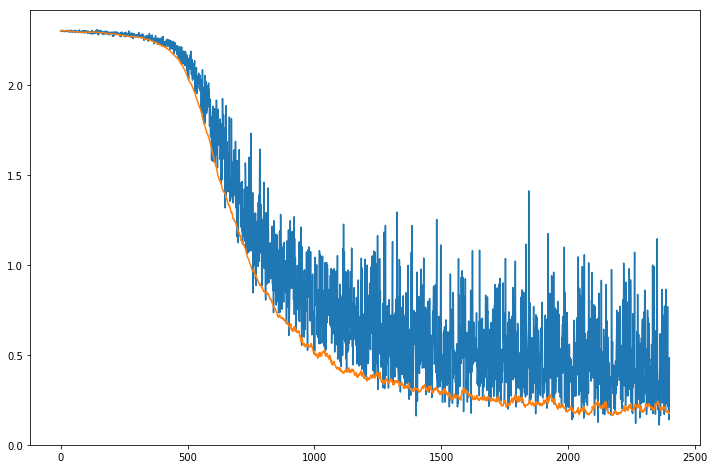

In [75]:
snn = ScratchSimpleNeuralNetrowkClassifier(lr=0.001, epoch=1)
snn.fit(X_train, y_train_one_hot, X_val, y_test_one_hot)

In [76]:
y_pred = snn.predict(X_val)

In [77]:
accuracy_score(y_val, y_pred)

0.8760833333333333

## 問題１：重みの初期値を決めるコードの作成

ScratchSimpleNeuralNetrowkClassifierクラス内の__init__（12行目以降）に実装

## 問題２：フォワードプロパゲーションの実装

ScratchSimpleNeuralNetrowkClassifierクラス内　137行目以降に実装  
また、191行目以降に活性化関数を定義  
activation_mathod（201行目）は、シグモイドとハイパボリックタンジェントを切り替えるための関数

## 問題３：交差エントロピー誤差の実装

ScratchSimpleNeuralNetrowkClassifierクラス内　175行目以降に実装

## 問題4：バックプロパゲーションの実装

ScratchSimpleNeuralNetrowkClassifierクラス内　151行目以降に実装  

## 問題5：推定

ScratchSimpleNeuralNetrowkClassifierクラス内　108行目以降に実装